<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/IBM_Neighborhoods_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting and Clustering Neighborhoods in Toronto

In [ ]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Scrap portal code from wikipedia

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [ ]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
r.content

b'\n<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of postal codes of Canada: M - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"2b659cee-fd7a-4a8d-9eb5-0bae434c8f62","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":960187814,"wgRevisionId":960187814,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Communications in Ontario","Postal codes in Canada","Toronto","Onta

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.content, "html5lib")

In [ ]:
table=soup.table
#table
#mw-content-text > div > table.wikitable.sortable.jquery-tablesorter

In [ ]:
#table.contents[1]

In [ ]:
print(len(table.contents[1]))

361


In [ ]:
Postal_code=[]
Borough=[]
Neighborhood=[]

newtable=table.contents[1]
iter_table = iter(newtable)
next(iter_table)
for name in iter_table:
  #print('------')
  #print(name)
  try:
    if name.select('td')[1].string.replace('\n','') == 'Not assigned':
      continue
    Postal_code.append(name.select('td')[0].string.replace('\n',''))
    Borough.append(name.select('td')[1].string.replace('\n',''))
    Neighborhood.append(name.select('td')[2].string.replace('\n',''))
  except:
    continue

# --- Question 1: Show dataframe Postal code scraping from Wiki pedia

In [ ]:
df=pd.DataFrame(list(zip(Postal_code,Borough,Neighborhood)),
             columns=['PostalCode','Borough','Neighborhood'])
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [ ]:
# Check duplicate name in PostalCode
df[df.duplicated(['PostalCode'])]

,PostalCode,Borough,Neighborhood


In [ ]:
# Check where 'Not assigned' in Neighborhood
df[df.Neighborhood == 'Not assigned']

,PostalCode,Borough,Neighborhood


In [ ]:
df.shape

(103, 3)

# Get latitude and longitude

In [ ]:
#!pip install geocoder

     |████████████████████████████████| 102kB 2.3MB/s 


1.Method from IBM (very long)

import geocoder # import geocoder

initialize your variable to None

lat_lng_coords = None
postal_code='M5G'

loop until you get the coordinates

while(lat_lng_coords is None):
  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
  lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
print(latitude,longitude)

2.Method from regular (previous lesson) --> not find full address
address = 'Ontario Provincial Government'
geolocator = Nominatim(user_agent="foursquare_agent") #from geopy
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

Goolemap method

In [ ]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.1-cp36-none-any.whl size=37819 sha256=918a88be25e942f1eb569121e94334e34c48ec0cc90ed9b5c8397065ed24c9a7
  Stored in directory: /root/.cache/pip/wheels/5c/ec/b9/9d0c26b80d7dcf16496c82e8108c93186c6d4df097a41bba4f
Successfully built googlemaps


In [ ]:
import googlemaps
path='/content/drive/My Drive/Data/API location file.csv'
googlemap_key=pd.read_csv(path).API[1]
gmaps = googlemaps.Client(key=googlemap_key)

In [ ]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [ ]:
latitude=[]
longitude=[]
for name in df.PostalCode:
  address=name+' , Toronto, Ontario'
  print(address)
  try:
    geocode_result = gmaps.geocode(address)
    latitude.append(geocode_result[0]['geometry']['location']['lat'])
    longitude.append(geocode_result[0]['geometry']['location']['lng'])
  except:
    latitude.append('nan')
    longitude.append('nan')
    continue

# -- Question 2: DataFrame contain latitude and longitude

In [ ]:
df['Latitude']=latitude
df['Longitude']=longitude
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [ ]:
df[df['Latitude']=='nan']

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,PostalCode,Borough,Neighborhood,Latitude,Longitude


In [ ]:
df.to_csv('/content/drive/My Drive/Data/IBM Toroto project.csv')

# Begin here (after scrapping data and get lat/lng from google API (save time running)

In [ ]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Data/IBM Toroto project.csv',index_col=0)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [ ]:
df.shape

(101, 5)

In [ ]:
df.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [ ]:
address = 'Parkwoods,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.7587999, -79.3201966.


In [ ]:
# create map of New York using latitude and longitude values
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

# --- Question 3: Explore and cluster the neighborhoods in North York Toronto

# Get the geographical coordinates of North York.

In [ ]:
df.Borough.value_counts()

North York          24
Downtown Toronto    17
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

In [ ]:
District_data = df[df['Borough'] == 'North York'].reset_index(drop=True)
District_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


In [ ]:
District_data.shape

(24, 5)

In [ ]:
address = 'M3A, North York, Toronton, Ontario'
geocode_result = gmaps.geocode(address)
latitude = geocode_result[0]['geometry']['location']['lat']
longitude =geocode_result[0]['geometry']['location']['lng']
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.7532586, -79.3296565.


In [ ]:
# create map of Manhattan using latitude and longitude values
map_District = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(District_data['Latitude'], District_data['Longitude'], District_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_District)  
    
map_District

## Define Foursquare Credentials and Version

In [ ]:
path='/content/drive/My Drive/Data/API location file.csv'
CLIENT_ID=pd.read_csv(path).API[4]
CLIENT_SECRET=pd.read_csv(path).API[6]

VERSION = '20180605' # Foursquare API version

## Let's explore the first neighborhood in our dataframe.

In [ ]:
District_data[:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


In [ ]:
District_data.loc[0, 'Neighborhood']

'Parkwoods'

Get the neighborhood's latitude and longitude values.

In [ ]:
neighborhood_latitude = District_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = District_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = District_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


Now, let's get the top 100 venues that are in Parkwoods within a radius of 500 meters.

In [ ]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [ ]:
results = requests.get(url).json()
#results

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Brookbanks Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.751976,-79.332140
1,Variety Store,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.751974,-79.333114


In [ ]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


## Explore Neighborhoods in NorthYork

In [ ]:
District_data.shape

(24, 5)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        #print(venues_list[3])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [ ]:
District_venues = getNearbyVenues(names=District_data['Neighborhood'],
                                   latitudes=District_data['Latitude'],
                                   longitudes=District_data['Longitude']
                                  )

Parkwoods
[[('Parkwoods', 43.7532586, -79.3296565, 'Brookbanks Park', 43.751976046055574, -79.33214044722958, 'Park'), ('Parkwoods', 43.7532586, -79.3296565, 'Variety Store', 43.75197441585782, -79.33311418516017, 'Food & Drink Shop')]]
Victoria Village
[[('Parkwoods', 43.7532586, -79.3296565, 'Brookbanks Park', 43.751976046055574, -79.33214044722958, 'Park'), ('Parkwoods', 43.7532586, -79.3296565, 'Variety Store', 43.75197441585782, -79.33311418516017, 'Food & Drink Shop')], [('Victoria Village', 43.72588229999999, -79.31557159999998, 'Victoria Village Arena', 43.72348055545508, -79.31563520925143, 'Hockey Arena'), ('Victoria Village', 43.72588229999999, -79.31557159999998, 'Tim Hortons', 43.725516631714754, -79.31310251366091, 'Coffee Shop'), ('Victoria Village', 43.72588229999999, -79.31557159999998, 'Portugril', 43.72581876267242, -79.31278541470671, 'Portuguese Restaurant'), ('Victoria Village', 43.72588229999999, -79.31557159999998, 'The Frig', 43.72705130603407, -79.317417609086

In [ ]:
District_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
244,"Willowdale, Willowdale West",43.782736,-79.442259,Shoppers Drug Mart,43.784847,-79.446028,Pharmacy
245,"Willowdale, Willowdale West",43.782736,-79.442259,RBC Royal Bank,43.783894,-79.446603,Bank
246,"Willowdale, Willowdale West",43.782736,-79.442259,Dollarama,43.784670,-79.446670,Discount Store
247,"Willowdale, Willowdale West",43.782736,-79.442259,Tim Hortons,43.780940,-79.444231,Coffee Shop


In [ ]:
District_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Don Mills,27,27,27,27,27,27
Downsview,17,17,17,17,17,17
"Fairview, Henry Farm, Oriole",65,65,65,65,65,65
Glencairn,5,5,5,5,5,5
Hillcrest Village,5,5,5,5,5,5
Humber Summit,1,1,1,1,1,1


In [ ]:
len(District_venues.groupby('Neighborhood').count())

19

In [ ]:
len(District_data.groupby('Neighborhood').count())

20

In [ ]:
District_venues.to_csv('/content/drive/My Drive/Data/IBM Toroto project_NorthYork.csv')

# Begin hear explore NorthYork_venues (after getting venue infor from Foursquare)

In [ ]:
District_venues=pd.read_csv('/content/drive/My Drive/Data/IBM Toroto project_NorthYork.csv',index_col=0)
District_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
244,"Willowdale, Willowdale West",43.782736,-79.442259,Shoppers Drug Mart,43.784847,-79.446028,Pharmacy
245,"Willowdale, Willowdale West",43.782736,-79.442259,RBC Royal Bank,43.783894,-79.446603,Bank
246,"Willowdale, Willowdale West",43.782736,-79.442259,Dollarama,43.784670,-79.446670,Discount Store
247,"Willowdale, Willowdale West",43.782736,-79.442259,Tim Hortons,43.780940,-79.444231,Coffee Shop


In [ ]:
District_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Don Mills,27,27,27,27,27,27
Downsview,17,17,17,17,17,17
"Fairview, Henry Farm, Oriole",65,65,65,65,65,65
Glencairn,5,5,5,5,5,5
Hillcrest Village,5,5,5,5,5,5
Humber Summit,1,1,1,1,1,1


In [ ]:
print('There are {} uniques categories.'.format(len(District_venues['Venue Category'].unique())))
# Park, Food drind, coffee shop

There are 105 uniques categories.


In [ ]:
District_data.shape

(24, 5)

In [ ]:
len(District_venues.groupby('Neighborhood'))

19

After find venue each district, some district did not have venue

# Analyze Each Neighborhood

In [ ]:
District_venues.head()
# Exame all vanue in each district

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [ ]:
District_venues.shape

(249, 7)

In [ ]:
# one hot encoding
District_venues_onehot = pd.get_dummies(District_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
District_venues_onehot['Neighborhood'] = District_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [District_venues_onehot.columns[-1]] + list(District_venues_onehot.columns[:-1])
District_venues_onehot = District_venues_onehot[fixed_columns]

District_venues_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,...,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
District_venues_onehot.shape

(249, 106)

In [ ]:
District_venues_onehot['Art Gallery'].value_counts()

0    248
1      1
Name: Art Gallery, dtype: int64

In [ ]:
District_venues_grouped = District_venues_onehot.groupby('Neighborhood').mean().reset_index()
District_venues_grouped.head()
#mean group: sum all value in group and divide total count in group
# purpose: find the most palace appear in each district_neighborhood

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,...,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.086957,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.043478,0.0,0.000000,0.086957,0.00,0.0,0.0,0.0,0.00,0.043478,0.0,0.0,0.000000,0.043478,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.00,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.000000,0.0,0.043478,0.043478,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.04,0.040000,0.000000,0.000000,0.0,0.000000,0.080000,0.04,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.04,0.000000,0.040000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040000,0.0,0.040000,0.0,0.0,0.0,0.04,0.0,0.080000,0.0,0.080000,0.0,0.000000,0.000000,0.0,0.000000,0.040000,0.0,0.04,0.0,0.04,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.000000,0.00,0.037037,0.0,0.074074,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074074,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.037037,0.037037,0.037037,0.0,0.037037,0.074074,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.037037,0.000000,0.037037,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.074074,0.0,0.037037,0.0,0.037037,0.037037,0.0,0.037037,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.058824,0.00,0.000000,0.0,0.000000,0.058824,0.0,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.117647,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
District_venues_grouped.shape

(19, 106)

print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in District_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = District_venues_grouped[District_venues_grouped['Neighborhood'] == hood].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0     Coffee Shop  0.09
1            Bank  0.09
2  Ice Cream Shop  0.04
3   Shopping Mall  0.04
4   Deli / Bodega  0.04


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1  Italian Restaurant  0.08
2         Coffee Shop  0.08
3          Restaurant  0.08
4    Greek Restaurant  0.04


----Don Mills----
                 venue  freq
0                  Gym  0.11
1     Asian Restaurant  0.07
2  Japanese Restaurant  0.07
3           Restaurant  0.07
4           Beer Store  0.07


----Downsview----
            venue  freq
0   Grocery Store  0.18
1            Park  0.12
2           Hotel  0.06
3  Baseball Field  0.06
4    Home Service  0.06


----Fairview, Henry Farm, Or

Function to sort the venues in descending order

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [ ]:
District_venues_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,...,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.086957,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.043478,0.0,0.000000,0.086957,0.00,0.0,0.0,0.0,0.00,0.043478,0.0,0.0,0.000000,0.043478,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.00,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.000000,0.0,0.043478,0.043478,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.04,0.040000,0.000000,0.000000,0.0,0.000000,0.080000,0.04,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.04,0.000000,0.040000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040000,0.0,0.040000,0.0,0.0,0.0,0.04,0.0,0.080000,0.0,0.080000,0.0,0.000000,0.000000,0.0,0.000000,0.040000,0.0,0.04,0.0,0.04,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.000000,0.00,0.037037,0.0,0.074074,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074074,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.037037,0.037037,0.037037,0.0,0.037037,0.074074,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.037037,0.000000,0.037037,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.074074,0.0,0.037037,0.0,0.037037,0.037037,0.0,0.037037,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.058824,0.00,0.000000,0.0,0.000000,0.058824,0.0,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.117647,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
row=District_venues_grouped.iloc[0, :]
row # Bathurst Manor, Wilson Heights, Downsview North (first Neighborhood)

Neighborhood             Bathurst Manor, Wilson Heights, Downsview North
Accessories Store                                                      0
Airport                                                                0
American Restaurant                                                    0
Art Gallery                                                            0
                                              ...                       
Toy / Game Store                                                       0
Trail                                                                  0
Video Game Store                                                       0
Vietnamese Restaurant                                                  0
Women's Store                                                          0
Name: 0, Length: 106, dtype: object

In [ ]:
row_categories = row.iloc[1:]
row_categories_sorted = row_categories.sort_values(ascending=False)
row_categories_sorted

Coffee Shop           0.0869565
Bank                  0.0869565
Chinese Restaurant    0.0434783
Park                  0.0434783
Pharmacy              0.0434783
                        ...    
Korean Restaurant             0
Liquor Store                  0
Lounge                        0
Luggage Store                 0
Accessories Store             0
Name: 0, Length: 105, dtype: object

In [ ]:
row_categories_sorted.index.values[0:num_top_venues]

array(['Coffee Shop', 'Bank', 'Chinese Restaurant', 'Park', 'Pharmacy',
       'Ice Cream Shop', 'Pizza Place', 'Bridal Shop',
       'Mobile Phone Shop', 'Diner'], dtype=object)

In [ ]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = District_venues_grouped['Neighborhood']
print(neighborhoods_venues_sorted)

for ind in np.arange(District_venues_grouped.shape[0]):
    print('ind',ind)
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(District_venues_grouped.iloc[ind, :], num_top_venues)
    print(neighborhoods_venues_sorted)
neighborhoods_venues_sorted.head()

                                       Neighborhood  ... 10th Most Common Venue
0   Bathurst Manor, Wilson Heights, Downsview North  ...                    NaN
1                                   Bayview Village  ...                    NaN
2                 Bedford Park, Lawrence Manor East  ...                    NaN
3                                         Don Mills  ...                    NaN
4                                         Downsview  ...                    NaN
5                      Fairview, Henry Farm, Oriole  ...                    NaN
6                                         Glencairn  ...                    NaN
7                                 Hillcrest Village  ...                    NaN
8                                     Humber Summit  ...                    NaN
9                                  Humberlea, Emery  ...                    NaN
10                 Lawrence Manor, Lawrence Heights  ...                    NaN
11         North Park, Maple Leaf Park, 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Chinese Restaurant,Park,Pharmacy,Ice Cream Shop,Pizza Place,Bridal Shop,Mobile Phone Shop,Diner
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Discount Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop
2,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Restaurant,Sandwich Place,Hobby Shop,Liquor Store,Comfort Food Restaurant,Café,Butcher,Juice Bar
3,Don Mills,Gym,Japanese Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Restaurant,Italian Restaurant,Dim Sum Restaurant,Discount Store,Bike Shop
4,Downsview,Grocery Store,Park,Baseball Field,Korean Restaurant,Liquor Store,Hotel,Home Service,Electronics Store,Shopping Mall,Business Service


# Cluster Neighborhoods

In [ ]:
District_venues_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,...,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.086957,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.043478,0.0,0.000000,0.086957,0.00,0.0,0.0,0.0,0.00,0.043478,0.0,0.0,0.000000,0.043478,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.00,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.000000,0.0,0.043478,0.043478,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.04,0.040000,0.000000,0.000000,0.0,0.000000,0.080000,0.04,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.04,0.000000,0.040000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040000,0.0,0.040000,0.0,0.0,0.0,0.04,0.0,0.080000,0.0,0.080000,0.0,0.000000,0.000000,0.0,0.000000,0.040000,0.0,0.04,0.0,0.04,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.000000,0.00,0.037037,0.0,0.074074,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074074,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.037037,0.037037,0.037037,0.0,0.037037,0.074074,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.037037,0.000000,0.037037,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.074074,0.0,0.037037,0.0,0.037037,0.037037,0.0,0.037037,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.058824,0.00,0.000000,0.0,0.000000,0.058824,0.0,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.00,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.117647,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
District_venues_grouped_cluster=District_venues_grouped.drop('Neighborhood', 1)
District_venues_grouped_cluster.head()

,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,...,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Video Game Store,Vietnamese Restaurant,Women's Store
0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.086957,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.043478,0.0,0.000000,0.086957,0.00,0.0,0.0,0.0,0.00,0.043478,0.0,0.0,0.000000,0.043478,0.000000,0.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.00,0.0,0.043478,0.0,0.043478,0.0,0.043478,0.000000,0.0,0.043478,0.043478,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.04,0.040000,0.000000,0.000000,0.0,0.000000,0.080000,0.04,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.04,0.000000,0.040000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040000,0.0,0.040000,0.0,0.0,0.0,0.04,0.0,0.080000,0.0,0.080000,0.0,0.000000,0.000000,0.0,0.000000,0.040000,0.0,0.04,0.0,0.04,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.00,0.037037,0.0,0.074074,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074074,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.037037,0.037037,0.037037,0.0,0.037037,0.074074,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.037037,0.000000,0.037037,0.0,...,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.074074,0.0,0.037037,0.0,0.037037,0.037037,0.0,0.037037,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,0.0,0.058824,0.00,0.000000,0.0,0.000000,0.058824,0.0,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.058824,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.117647,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


Find the best cluster by kMeans_inertia

In [ ]:
n_clusters = 10
#n_init = 10
#max_iter = 300
#tol = 0.0001
#random_state = 2018
#n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,15), #21
                              columns=['inertia'])
kmeans_per_k = []
k_range = range(2,n_clusters)
for n_clusters in k_range:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, 
                    #n_init=n_init,max_iter=max_iter, 
                    #tol=tol, random_state=random_state, n_jobs=n_jobs
                    )
    kmeans.fit(District_venues_grouped_cluster)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    kmeans_per_k.append(kmeans)

2
3
4
5
6
7
8
9


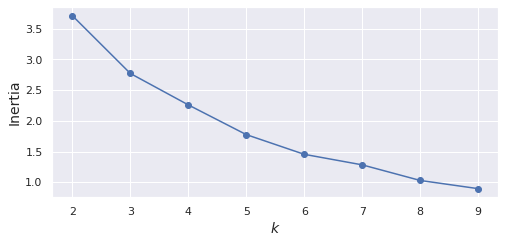

In [ ]:
#k_range = range(2,15)
inertias = [model.inertia_ for model in kmeans_per_k]
#best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
#plt.plot(best_k, best_inertia, "rs")
plt.show()

Best cluster: 4

Find the best cluster by kMeans silhouette

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
score_df=[]
for n_clusters in k_range:
    #print(n_clusters)
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(District_venues_grouped_cluster)
    score = silhouette_score(District_venues_grouped_cluster, preds)
    score_df.append(score)
    #print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
score_df=pd.DataFrame(score_df)
score_df

,0
0,0.423058
1,0.428248
2,0.213879
3,0.229042
4,0.198517
5,0.165319
6,0.116620
7,0.088917


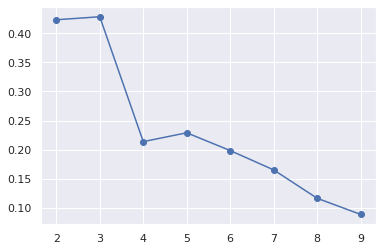

In [ ]:
plt.plot(k_range, score_df, "bo-")

Best cluster: 3

# Run k-means to cluster the neighborhood into 3 clusters.

In [ ]:
from collections import Counter

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(District_venues_grouped_cluster)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
Counter(kmeans.labels_)

Counter({0: 17, 1: 1, 2: 1})

In [ ]:
neighborhoods_venues_sorted.head(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Chinese Restaurant,Park,Pharmacy,Ice Cream Shop,Pizza Place,Bridal Shop,Mobile Phone Shop,Diner
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Discount Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop


In [ ]:
District_data.head(2)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572


In [ ]:
print(neighborhoods_venues_sorted.shape)
print(District_data.shape) # District data group neighborhoods is the same lenght as neighborhoods_vene

(19, 11)
(24, 5)


In [ ]:
# add clustering labels
neighborhoods_venues_sorted_=neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted_.insert(0, 'Cluster Labels', kmeans.labels_)

District_merged = District_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
District_merged = District_merged.join(neighborhoods_venues_sorted_.set_index('Neighborhood'), on='Neighborhood')
District_merged=District_merged.dropna()
District_merged['Cluster Labels']=District_merged['Cluster Labels'].astype('int')
District_merged # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Coffee Shop,French Restaurant,Hockey Arena,Pizza Place,Portuguese Restaurant,Women's Store,Dim Sum Restaurant,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Women's Store,Miscellaneous Shop,Boutique,Coffee Shop,Event Space,Furniture / Home Store,Gift Shop,Vietnamese Restaurant,Accessories Store
3,M3B,North York,Don Mills,43.745906,-79.352188,0,Gym,Japanese Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Restaurant,Italian Restaurant,Dim Sum Restaurant,Discount Store,Bike Shop
4,M6B,North York,Glencairn,43.709577,-79.445073,0,Asian Restaurant,Sushi Restaurant,Pizza Place,Pub,Japanese Restaurant,Women's Store,Dim Sum Restaurant,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping
5,M3C,North York,Don Mills,43.725900,-79.340923,0,Gym,Japanese Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Restaurant,Italian Restaurant,Dim Sum Restaurant,Discount Store,Bike Shop
6,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,Golf Course,Mediterranean Restaurant,Athletics & Sports,Pool,Dog Run,Diner,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
7,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,Coffee Shop,Bank,Chinese Restaurant,Park,Pharmacy,Ice Cream Shop,Pizza Place,Bridal Shop,Mobile Phone Shop,Diner
8,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Juice Bar,Japanese Restaurant,Women's Store,Toy / Game Store,Bank,Bakery
9,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,0,Furniture / Home Store,Caribbean Restaurant,Metro Station,Massage Studio,Bar,Coffee Shop,Women's Store,Dim Sum Restaurant,Construction & Landscaping,Convenience Store


In [ ]:
District_merged.shape # drop one row with na value

(23, 16)

In [ ]:
District_data.shape

(24, 5)

In [ ]:
District_merged.isnull().sum()

PostalCode                0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(District_merged['Latitude'], District_merged['Longitude'],
                                  District_merged['Neighborhood'], District_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [ ]:
Cluster_Labels=0
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0,Park,Food & Drink Shop,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
1,North York,0,Coffee Shop,French Restaurant,Hockey Arena,Pizza Place,Portuguese Restaurant,Women's Store,Dim Sum Restaurant,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
2,North York,0,Clothing Store,Women's Store,Miscellaneous Shop,Boutique,Coffee Shop,Event Space,Furniture / Home Store,Gift Shop,Vietnamese Restaurant,Accessories Store
3,North York,0,Gym,Japanese Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Restaurant,Italian Restaurant,Dim Sum Restaurant,Discount Store,Bike Shop
4,North York,0,Asian Restaurant,Sushi Restaurant,Pizza Place,Pub,Japanese Restaurant,Women's Store,Dim Sum Restaurant,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping
5,North York,0,Gym,Japanese Restaurant,Coffee Shop,Asian Restaurant,Beer Store,Restaurant,Italian Restaurant,Dim Sum Restaurant,Discount Store,Bike Shop
6,North York,0,Golf Course,Mediterranean Restaurant,Athletics & Sports,Pool,Dog Run,Diner,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
7,North York,0,Coffee Shop,Bank,Chinese Restaurant,Park,Pharmacy,Ice Cream Shop,Pizza Place,Bridal Shop,Mobile Phone Shop,Diner
8,North York,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Juice Bar,Japanese Restaurant,Women's Store,Toy / Game Store,Bank,Bakery
9,North York,0,Furniture / Home Store,Caribbean Restaurant,Metro Station,Massage Studio,Bar,Coffee Shop,Women's Store,Dim Sum Restaurant,Construction & Landscaping,Convenience Store


In [ ]:
Cluster_Labels=1
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,North York,1,Furniture / Home Store,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega


In [ ]:
Cluster_Labels=2
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,North York,2,Piano Bar,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega


# --- Question 3 (expanded): Explore and cluster the neighborhoods in all Toronto

In [ ]:
address = 'Parkwoods,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.7587999, -79.3201966.


In [ ]:
# create map of New York using latitude and longitude values
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

In [ ]:
path='/content/drive/My Drive/Data/API location file.csv'
CLIENT_ID=pd.read_csv(path).API[4]
CLIENT_SECRET=pd.read_csv(path).API[6]

VERSION = '20180605' # Foursquare API version

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        #print(venues_list[3])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [ ]:
df[:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [ ]:
District_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village


In [ ]:
District_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
1994,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,RONA,43.629393,-79.518320,Hardware Store
1995,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Royal Canadian Legion #210,43.628855,-79.518903,Social Club
1996,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
1997,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store


In [ ]:
District_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,3,3,3,3,3,3


In [ ]:
len(District_venues.groupby('Neighborhood').count())

93

In [ ]:
len(df.groupby('Neighborhood').count()) # Neighborhood of all district

97

In [ ]:
District_venues.to_csv('/content/drive/My Drive/Data/IBM Toroto project_all Toronto_foursquare.csv')

# Begin hear explore all Toronto venue (after getting venue infor from Foursquare)

In [ ]:
District_venues=pd.read_csv('/content/drive/My Drive/Data/IBM Toroto project_all Toronto_foursquare.csv',index_col=0)
District_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
1994,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,RONA,43.629393,-79.518320,Hardware Store
1995,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Royal Canadian Legion #210,43.628855,-79.518903,Social Club
1996,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
1997,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store


In [ ]:
print('There are {} uniques categories.'.format(len(District_venues['Venue Category'].unique())))
# Park, Food drind, coffee shop

There are 271 uniques categories.


In [ ]:
District_venues.head()
# Exame all vanue in each district

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [ ]:
District_venues.shape

(1999, 7)

In [ ]:
# one hot encoding
District_venues_onehot = pd.get_dummies(District_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
District_venues_onehot['Neighborhood'] = District_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [District_venues_onehot.columns[-1]] + list(District_venues_onehot.columns[:-1])
District_venues_onehot = District_venues_onehot[fixed_columns]

District_venues_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
District_venues_grouped = District_venues_onehot.groupby('Neighborhood').mean().reset_index()
District_venues_grouped.head()
#mean group: sum all value in group and divide total count in group
# purpose: find the most palace appear in each district_neighborhood

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
District_venues_grouped.shape

(93, 271)

In [ ]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = District_venues_grouped['Neighborhood']
#print(neighborhoods_venues_sorted)

for ind in np.arange(District_venues_grouped.shape[0]):
    #print('ind',ind)
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(District_venues_grouped.iloc[ind, :], num_top_venues)
    #print(neighborhoods_venues_sorted)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Clothing Store,Breakfast Spot,Latin American Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Dance Studio,Pharmacy,Coffee Shop,Pub,Gym,Airport Service,Falafel Restaurant,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Chinese Restaurant,Middle Eastern Restaurant,Supermarket,Restaurant,Sushi Restaurant,Shopping Mall,Ice Cream Shop
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Restaurant,Italian Restaurant,Sushi Restaurant,Pub,Indian Restaurant,Café,Cupcake Shop,Juice Bar


In [ ]:
neighborhoods_venues_sorted.shape

(93, 11)

# Cluster Neighborhoods

In [ ]:
District_venues_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
District_venues_grouped_cluster=District_venues_grouped.drop('Neighborhood', 1)
District_venues_grouped_cluster.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
n_clusters = 10
#n_init = 10
#max_iter = 300
#tol = 0.0001
#random_state = 2018
#n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,15), #21
                              columns=['inertia'])
kmeans_per_k = []
k_range = range(2,n_clusters)
for n_clusters in k_range:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, 
                    #n_init=n_init,max_iter=max_iter, 
                    #tol=tol, random_state=random_state, n_jobs=n_jobs
                    )
    kmeans.fit(District_venues_grouped_cluster)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    kmeans_per_k.append(kmeans)

2
3
4
5
6
7
8
9


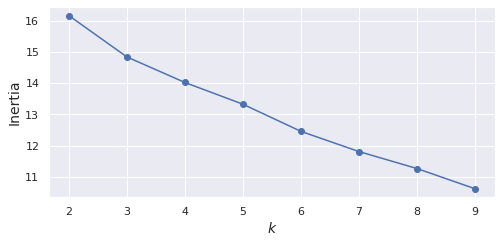

In [ ]:
#k_range = range(2,15)
inertias = [model.inertia_ for model in kmeans_per_k]
#best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
#plt.plot(best_k, best_inertia, "rs")
plt.show()

In [ ]:
score_df=[]
for n_clusters in k_range:
    #print(n_clusters)
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(District_venues_grouped_cluster)
    score = silhouette_score(District_venues_grouped_cluster, preds)
    score_df.append(score)
    #print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
score_df=pd.DataFrame(score_df)
score_df

,0
0,0.313356
1,0.278872
2,0.292743
3,0.292356
4,0.045153
5,0.300273
6,0.290494
7,0.201349


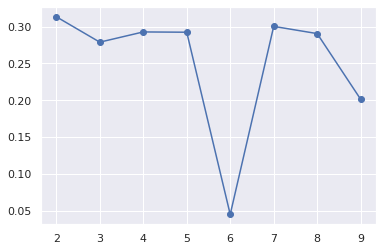

In [ ]:
plt.plot(k_range, score_df, "bo-")

# Run k-means to cluster the neighborhood into 3 clusters.

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(District_venues_grouped_cluster)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
Counter(kmeans.labels_)

Counter({0: 4, 1: 82, 2: 7})

In [ ]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Clothing Store,Breakfast Spot,Latin American Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Dance Studio,Pharmacy,Coffee Shop,Pub,Gym,Airport Service,Falafel Restaurant,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Chinese Restaurant,Middle Eastern Restaurant,Supermarket,Restaurant,Sushi Restaurant,Shopping Mall,Ice Cream Shop
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Restaurant,Italian Restaurant,Sushi Restaurant,Pub,Indian Restaurant,Café,Cupcake Shop,Juice Bar
...,...,...,...,...,...,...,...,...,...,...,...
88,"Willowdale, Willowdale East",Ramen Restaurant,Japanese Restaurant,Coffee Shop,Pizza Place,Café,Sushi Restaurant,Sandwich Place,Electronics Store,Juice Bar,Restaurant
89,"Willowdale, Willowdale West",Pizza Place,Bank,Coffee Shop,Discount Store,Pharmacy,Grocery Store,Gourmet Shop,Golf Course,Eastern European Restaurant,Drugstore
90,Woburn,Coffee Shop,Korean Restaurant,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
91,Woodbine Heights,Pharmacy,Curling Ice,Park,Skating Rink,Beer Store,Athletics & Sports,Bus Stop,Discount Store,Dessert Shop,Dim Sum Restaurant


In [ ]:
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [ ]:
print(neighborhoods_venues_sorted.shape)
print(df.shape) # District data group neighborhoods is the same lenght as neighborhoods_vene
# may be some neighborhoods is the same name in each district (93 # 101)

(93, 11)
(101, 5)


In [ ]:
# add clustering labels
neighborhoods_venues_sorted_=neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted_.insert(0, 'Cluster Labels', kmeans.labels_)

District_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
District_merged = District_merged.join(neighborhoods_venues_sorted_.set_index('Neighborhood'), on='Neighborhood')
District_merged=District_merged.dropna()
District_merged['Cluster Labels']=District_merged['Cluster Labels'].astype('int')
District_merged # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Food & Drink Shop,Park,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Pizza Place,Coffee Shop,French Restaurant,Portuguese Restaurant,Hockey Arena,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Breakfast Spot,Restaurant,Café,Pub,Theater,Farmers Market,Event Space
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Women's Store,Accessories Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Coffee Shop,Event Space,Gift Shop,Miscellaneous Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Diner,Yoga Studio,Arts & Crafts Store,Sandwich Place,Burrito Place,Smoothie Shop,Beer Bar,Mexican Restaurant,Italian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1,River,Park,Smoke Shop,Pool,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Hotel,Men's Store,Mediterranean Restaurant,Pub
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,1,Yoga Studio,Garden Center,Smoke Shop,Park,Brewery,Light Rail Station,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,1,Deli / Bodega,Baseball Field,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Farmers Market


In [ ]:
District_merged.shape

(97, 16)

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(District_merged['Latitude'], District_merged['Longitude'],
                                  District_merged['Neighborhood'], District_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [ ]:
Cluster_Labels=0
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,East York,0,Convenience Store,Park,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
63,York,0,Pizza Place,Convenience Store,Bus Line,Breakfast Spot,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
64,York,0,Convenience Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Deli / Bodega
66,North York,0,Convenience Store,Park,Construction & Landscaping,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


In [ ]:
Cluster_Labels=1
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Pizza Place,Coffee Shop,French Restaurant,Portuguese Restaurant,Hockey Arena,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,Downtown Toronto,1,Coffee Shop,Park,Bakery,Breakfast Spot,Restaurant,Café,Pub,Theater,Farmers Market,Event Space
3,North York,1,Clothing Store,Women's Store,Accessories Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Coffee Shop,Event Space,Gift Shop,Miscellaneous Shop
4,Downtown Toronto,1,Coffee Shop,Diner,Yoga Studio,Arts & Crafts Store,Sandwich Place,Burrito Place,Smoothie Shop,Beer Bar,Mexican Restaurant,Italian Restaurant
6,Scarborough,1,Print Shop,Fast Food Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Etobicoke,1,River,Park,Smoke Shop,Pool,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
99,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Hotel,Men's Store,Mediterranean Restaurant,Pub
100,East Toronto,1,Yoga Studio,Garden Center,Smoke Shop,Park,Brewery,Light Rail Station,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant
101,Etobicoke,1,Deli / Bodega,Baseball Field,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Farmers Market


In [ ]:
Cluster_Labels=2
District_merged.loc[District_merged['Cluster Labels'] == Cluster_Labels,
                    District_merged.columns[[1] + \
                    list(range(5, District_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Food & Drink Shop,Park,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
21,York,2,Park,Women's Store,Pool,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
32,Scarborough,2,Playground,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
61,Central Toronto,2,Park,Bus Line,Swim School,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
83,Central Toronto,2,Playground,Restaurant,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
85,Scarborough,2,Playground,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
91,Downtown Toronto,2,Park,Trail,Playground,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
